# Solving Seating Optimization with *sasoptpy*

In [1]:
import numpy as np
import pandas as pd
import sasoptpy as so
import itertools
from functools import lru_cache
from math import sqrt, pi
from ipycanvas import Canvas
import time
import os
import sys

In [2]:
# Create a Viya connection
from swat import CAS
CASHOST=os.getenv('CASHOST')
CASPORT=os.getenv('CASPORT')
s = CAS(CASHOST, CASPORT)

In [3]:
# Auxiliary functions
def get_set_of_n(section, n):
    # Gives groups of "n" tickets, that are next to each other for every row
    
    groups = []
    for row in section:
        j = [row[i:] for i in range(n)]
        e = [list(a) for a in zip(*j)]
        f = []
        for i in e:
            f.append('n'.join(i))
        groups.extend(f)
    return groups

def get_seats_nearby(group_original, all_seats_original, limit):
    # Gives a set of the seats that are too close to the given group
    
    group = [[int(i) for i in g.split('_')] for g in group_original.split('n')]
    all_seats = [[int(i) for i in g.split('_')] for a in all_seats_original for g in a.split('n') ]
    infeasible_set = []
    for v, i in enumerate(all_seats):
        if i in group:
            continue
        for j in group:
            if sqrt((i[0]-j[0])**2 + (i[1]-j[1])**2) <= limit:
                infeasible_set.append(all_seats_original[v])
                break
    return infeasible_set

def get_groups_nearby(group_original, all_seats_original, all_groups, limit):
    # Gives a set of groups that are too close to the given group
    
    nearby_seats = get_seats_nearby(group_original, all_seats_original, limit)
    fset = []
    for s in nearby_seats:
        for i in all_groups:
            if (s in i) and (i != group_original):
                fset.append(i)
    infset = f7(fset)
    return infset

# from http://www.peterbe.com/plog/uniqifiers-benchmark
def f7(seq):
    # Drops duplicates in a list
    
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [4]:
def generate_data(ROWS, COLS, SEAT_DIST, only=None, MAX_GROUP_SIZE=4):
    # Generates data for a perfect grid layout
    
    N = range(ROWS)
    M = range(COLS)
    L = SEAT_DIST
    
    section = [[f'{i:02d}_{j:02d}' for j in M] for i in N]
    section_df = pd.DataFrame(section)
    print(section_df)
    
    SEATS = [section_df.at[i, j] for i in N for j in M]
    if only is None:
        ALL_SETS_OF_N = [get_set_of_n(section, i+1) for i in range(MAX_GROUP_SIZE)]
        return [j for i in ALL_SETS_OF_N for j in i], SEATS
    else:
        return get_set_of_n(section, only), SEATS

In [5]:
def solve_seating_problem(session, data, lower_target, upper_target):
    # Defines and solves the optimization problem. Target levels may be given.
    
    ALL_GROUPS = data['ALL_GROUPS']
    SEATS = data['SEATS']
    L = data['L']
    
    # MODEL
    m = so.Model(name='seating_model', session=session)
    
    # VARS
    x = m.add_variables(ALL_GROUPS, vartype=so.binary, name='x')
    
    # CONSTRAINTS
    group_once = m.add_constraints(
        (so.expr_sum(x[i] for i in ALL_GROUPS if s in i) <= 1 for s in SEATS), name='group_once')
    
    security_constraints = m.add_constraints(
        (so.expr_sum(x[i]
                     for i in get_groups_nearby(g, SEATS, ALL_GROUPS, L))
         <= (1-x[g])*len(get_groups_nearby(g, SEATS, ALL_GROUPS, L))
         for g in ALL_GROUPS), name='security_constraint')
    
    sum_of_viewers = so.expr_sum((i.count('n')+1) * x[i] for i in ALL_GROUPS)
    
    if lower_target is not None:
        m.add_constraint(sum_of_viewers >= lower_target, name='objlb')
    if upper_target is not None:
        m.add_constraint(sum_of_viewers <= upper_target, name='objub')
    m.set_objective(sum_of_viewers, sense=so.maximize, name='total_viewers')
    #m.tune_parameters(tunerParameters={'maxConfigs': 20})
    m.solve(options={'with': 'milp', 'maxtime': 180})
    return m

In [6]:
def parse_solution(m):
    # Produces a list of selected seats and groups
    
    selected_seats = []
    seating_groups = []
    for r in m.get_solution().itertuples():
        g1 = []
        if r.value > 0.5:
            print(r.var)
            s1 = r.var.split('\'')[1].split('n')
            for i in s1:
                cseat = tuple(int(j) for j in i.split('_'))
                selected_seats.append(cseat)
                g1.append(cseat)
            seating_groups.append(g1)

    return selected_seats, seating_groups

In [7]:
def draw_solution(N, M, L, selected_seats, seating_groups):
    # Creates a canvas to display result

    W = 600
    margin = 50
    gap = 10
    d = int((W-2*margin)/(len(M)))
    H = d * len(N) + 2 * margin
    radius = L * d
    seat = d-gap
    canvas = Canvas(width=W, height=H)
    canvas.text_align = 'center'
    canvas.text_baseline = 'middle'

    stm = margin + gap/2

    for i in N:
        for j in M:
            canvas.fill_style = 'lightgray'
            canvas.fill_rect(stm + j*d, margin +  i*d, seat, seat)
            canvas.fill_style = 'gray'
            canvas.fill_rect(stm + j*d, margin +  i*d + int(3*d/5), seat, 1)
            canvas.fill_style = 'black'
            canvas.fill_text(f'({i}, {j})', stm+j*d+int(seat/2), margin+i*d+int(seat/2.5) - 5, 32)

    canvas.fill_style = 'rgba(67, 168, 84, 0.50)'
    for i in selected_seats:
        canvas.fill_rect(stm+3 + i[1] * d, margin+3 + i[0] * d, d-gap-6, d-gap-6)

    canvas.fill_style = 'rgba(221, 52, 14, 0.55)'
    for i in selected_seats:
        canvas.fill_arc(stm + i[1] * d + int(seat/2), margin + i[0]*d + int(seat/2), int(seat/10), 0, 2*pi, anticlockwise=False)

    canvas.stroke_style = 'rgba(221, 52, 14, 0.7)'
    for g in seating_groups:
        #canvas.fill_style = 'rgba(221, 52, 14, 0.05)'
        f0 = g[0]
        f1 = g[-1]
        left_center = stm + f0[1] * d + int(seat/2), margin + f0[0]*d + int(seat/2)
        right_center = stm + f1[1] * d + int(seat/2), margin + f1[0]*d + int(seat/2)

        canvas.begin_path()
        canvas.arc(left_center[0], left_center[1], radius, pi/2, 3*pi/2, anticlockwise=False)
        canvas.move_to(left_center[0], left_center[1]-radius)
        canvas.line_to(right_center[0], right_center[1]-radius)
        canvas.stroke()
        canvas.move_to(right_center[0], right_center[1]+radius)
        canvas.arc(right_center[0], right_center[1], radius, pi/2, 3*pi/2, anticlockwise=True)
        canvas.stroke()
        canvas.move_to(right_center[0], right_center[1]+radius)
        canvas.line_to(left_center[0], left_center[1]+radius)
        canvas.stroke()
    
    return canvas


In [8]:
def define_and_solve(rows, cols, distance, only=None, lb=None, ub=None, max_group=4):
    # Combines all the functions: Generate data, solve problem, parse solution and draw the canvas
    
    AG, ST = generate_data(rows, cols, distance, only, max_group)
    m = solve_seating_problem(s, {'ALL_GROUPS': AG, 'SEATS': ST, 'L': distance}, lb, ub)
    SS, SG = parse_solution(m)
    c = draw_solution(range(rows), range(cols), distance, SS, SG)
    return c, m

In [9]:
class HiddenPrints:
    # It is used for hiding logs during optimization
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [10]:
from ipywidgets import VBox, HBox, Box, Layout, BoundedFloatText, Button, HTML, Label

In [11]:
# Create a single-page web application

# Control (on top)

style = {'description_width':'130px'}
layout = {'width': '300px'}
rows = BoundedFloatText(value=7, min=1, max=50, description='Rows:', style=style, layout=layout)
cols = BoundedFloatText(value=7, min=1, max=15, description='Columns:', style=style, layout=layout)
dist = BoundedFloatText(value=4, min=0, max=5, description='Distance:', style=style, layout=layout)
maxg = BoundedFloatText(value=2, min=1, max=10, description='Max Group Size:', style=style, layout=layout)
styp = BoundedFloatText(value=0, min=0, max=5, description='Fixed Group Size:', style=style, layout=layout)

opt_button = Button(description='Optimize')

control_box = VBox([rows, cols, dist, maxg, styp, opt_button], layout=Layout(width='100%', align_items='center'))


divider = HBox(layout=Layout(border='1px solid black', margin='auto', height='0px', width='90%'))

# # Canvas (on bottom)

load_img = HTML(value='<span style="height: 24px">&nbsp;</span>')
message_label = Label('')
canvas_box = Box([], layout=Layout(margin='0 auto', min_height='800px', align_items='center'))

left_box = VBox([load_img, message_label, canvas_box], layout=Layout(width='70%', margin='0', align_items='center'))

bdivider = VBox(layout=Layout(border='1px solid black', margin='10px', width='0px'))

def seat_text(val=None):
    if val is None:
        val = "--"
    return f"<center><font size='6pt'><b>Seats</b>:<br/>{val}</font></center><br/>"
def util_text(val=None):
    if val is None:
        val = "--.--"
    return f"<center><font size='6pt'><b>Utilization</b>:<br/>{val}%</font></center>"

label1 = HTML(value = seat_text())
label2 = HTML(value = util_text())
right_box = VBox([label1, label2], layout=Layout(width='30%', margin='56px 0px 0px 0px', align_items='center'))

bottom_box = HBox([left_box, bdivider, right_box], layout=Layout())


def reoptimize(b):
    canvas_box.children = []
    load_img.value = "<img src='loader.svg' />"
    message_label.value = "Optimizing..."
    label1.value = seat_text()
    label2.value = util_text()
    time.sleep(0.1)
    only = int(styp.value) if styp.value != 0 else None
    with HiddenPrints():
        c, m = define_and_solve(rows=int(rows.value), cols=int(cols.value), distance=dist.value, only=only, max_group=int(maxg.value))
    time.sleep(0.1)
    label1.value = seat_text(int(m.get_objective_value()))
    label2.value = util_text(f"{100*m.get_objective_value()/(rows.value*cols.value):.2f}")
    
    
    load_img.value = '<span style="height: 24px">&nbsp;</span>'
    message_label.value = ''
    time.sleep(0.1)
    canvas_box.children = [c,]

opt_button.on_click(reoptimize)

widget = VBox([control_box, divider, bottom_box], layout=Layout(width='100%', min_height='80px', border='1px solid black'))

In [12]:
widget

In [14]:
define_and_solve(rows=7, cols=7, distance=4, max_group=4)[0]

       0      1      2      3      4      5      6
0  00_00  00_01  00_02  00_03  00_04  00_05  00_06
1  01_00  01_01  01_02  01_03  01_04  01_05  01_06
2  02_00  02_01  02_02  02_03  02_04  02_05  02_06
3  03_00  03_01  03_02  03_03  03_04  03_05  03_06
4  04_00  04_01  04_02  04_03  04_04  04_05  04_06
5  05_00  05_01  05_02  05_03  05_04  05_05  05_06
6  06_00  06_01  06_02  06_03  06_04  06_05  06_06
NOTE: Initialized model seating_model.
NOTE: Added action set 'optimization'.
NOTE: Converting model seating_model to OPTMODEL.
NOTE: Submitting OPTMODEL code to CAS server.
NOTE: Problem generation will use 8 threads.
NOTE: The problem has 154 variables (0 free, 0 fixed).
NOTE: The problem has 154 binary and 0 integer variables.
NOTE: The problem has 203 linear constraints (203 LE, 0 EQ, 0 GE, 0 range).
NOTE: The problem has 17969 linear constraint coefficients.
NOTE: The problem has 0 nonlinear constraints (0 LE, 0 EQ, 0 GE, 0 range).
NOTE: The remaining solution time after problem g

Canvas(height=597, width=600)

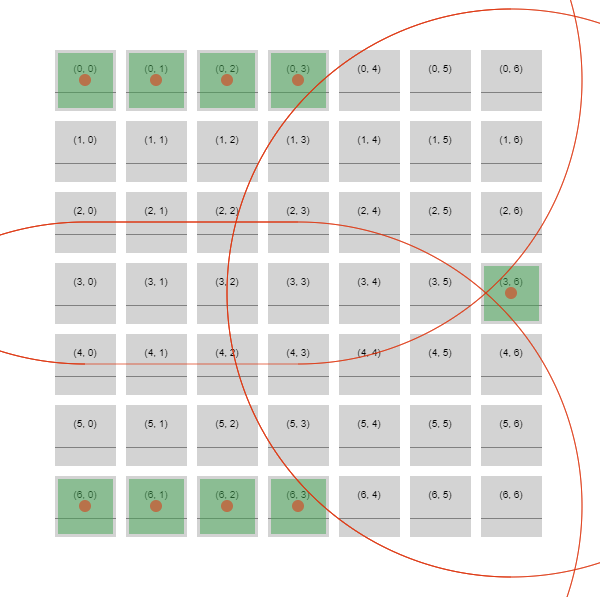

In [15]:
# Display sample output (for Web View)
from IPython.display import Image
Image(filename='sample_seating.png') 